# Introduction
This code deals with the 2D plane-strain simulation of a circular tunnel made of fiber-reinforced concrete subjected to in-situ earth pressures transmitted by surrounding soil, where the material behaivor is described by the elasto-plastic Drucker-Prager model with a linear shear softening law defined in terms of the cohesion. Since the focus here is to analyze the response of the concrete structure, the true behavior of the soil as well as the interface interaction is disregarded for simplicity. The soil is modeled as a linear elastic body by imposing an artificially large cohesion. The gravity is disregarded and the in-situ stresses are assumed to be uniformly distributed along the domain boundaries. The implementation is done with Firedrake, an automated system for finite element method solution, in Google Colab.

In [ ]:
# make plots appear in the notebook
%matplotlib inline 

# import necessary Python libraries
import matplotlib.pyplot as plt
import numpy as np

# access Google Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

# load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from firedrake import *

In [ ]:
# create an output directory and make it the current one 
import os
!mkdir out_files
os.chdir('out_files')

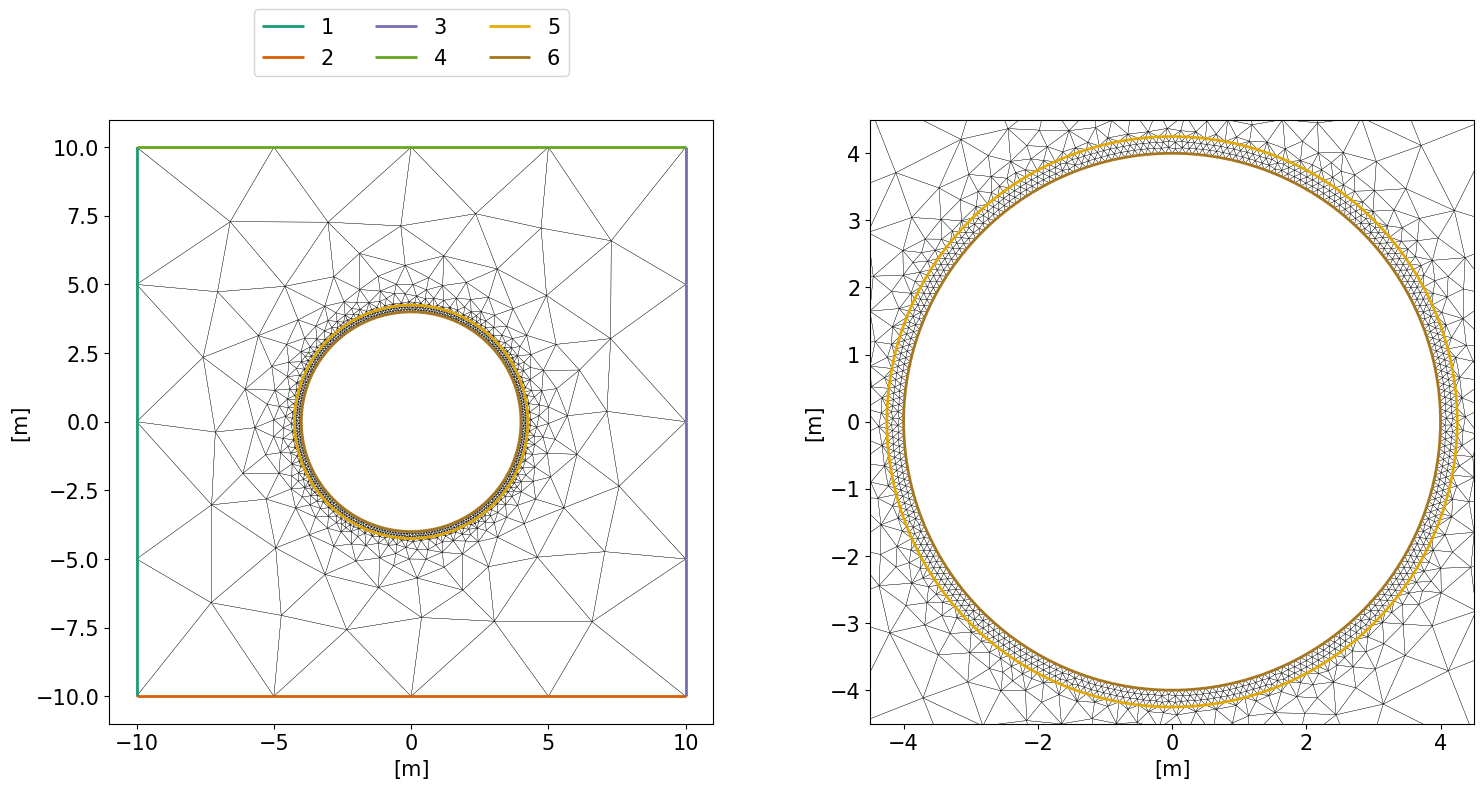

In [ ]:
# domain geometry: 20 m x 20 m; tunnel geometry: internal radius = 4 m, thickness = 0.25 m
# load the mesh generated with Gmsh
mesh = Mesh('/content/drive/My Drive/Colab Notebooks/tunnel_circ_small.msh')

# plot the mesh
fig, axes = plt.subplots(1,2, figsize=(18, 8), dpi=100)
triplot(mesh, axes=axes[0], interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes[0].set_aspect("equal")
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3);
axes[0].set(xlabel='[m]', ylabel='[m]');
triplot(mesh, axes=axes[1], interior_kw={'linewidth': 0.2}, boundary_kw={'linewidth': 2})
axes[1].set_aspect("equal")
axes[1].set_xlim([-4.5, 4.5]);
axes[1].set_ylim([-4.5, 4.5]);
axes[1].set(xlabel='[m]', ylabel='[m]');
plt.rcParams.update({'font.size': 20})

# Implementation
2D quadratic elements are used. A standard "CG" space is defined for the displacement (2-dimensional vector) whereas the stress (4-dimensional vector) and the cumulative plastic strain (scalar) are represented using "Quadrature" elements. The components in the stress vector are placed in the order: [$\sigma_{xx}$, $\sigma_{yy}$, $\tau_{xy}$, $\sigma_{zz}$].

In [ ]:
## define FE function spaces ##
# CG: standard scalar Lagrange finite elements (continuous piecewise polynomial functions)
# Quadrature: artificial "finite elements" with degrees of freedom being function evaluations at quadrature points
# DG: scalar discontinuous Lagrange finite elements (discontinuous piecewise polynomial functions)

deg_u = 2 # degree of the CG element
deg_stress = 2 # degree of the Quadrature element

V = VectorFunctionSpace(mesh, "CG", deg_u) # for displacement vector (u)

We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default') 
W = FunctionSpace(mesh, We) # for stress vector (sig) and flow orientation vector (N)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e) # for internal scalars (A, B, eps_p, check)

P0 = FunctionSpace(mesh, "DG", 0) # for material properties (E, nu, c) and output of equivalent plastic strain (ep_avg)
S0 = VectorFunctionSpace(mesh, "DG", 1, dim=3) # for output of in-plane stress vector (sig_vector)

# a custom integration measure to match the quadrature degree and scheme used by the Quadrature elements   
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

In [ ]:
# define functions to keep track of the state in the currently computed increment
u = Function(V, name="Displacement")
du = Function(V, name="Global iteration correction")
Du = Function(V, name="Current displacement increment")
u_ = TrialFunction(V)
v = TestFunction(V)

sig = Function(W, name="Stress")
sig_old = Function(W) # converged stress from the previous global increment
N = Function(W) # flow orientation vector

A = Function(W0) # a scalar for defining the consistent tangent operator 
B = Function(W0) # a scalar for defining the consistent tangent operator 
eps_p = Function(W0, name="Cumulative plastic strain")
check = Function(W0) # a scalar for selecting between return to the smooth surface and return to the apex

ep_avg = Function(P0, name="Equivalent plastic strain") 
sig_vector = Function(S0, name="In-plane stresses")

In [ ]:
def cell_project(v, V):
    '''
    Project an expression 'v' onto a cell-based function space 'V'.
    If 'v' is a dictionary of the kind {region_1: value_1, region_2: value_2, ...}, then project 
    different expressions (value_i) on subdomains with corresponding cell markers (region_i). 
    '''
    v_, dv = TestFunction(V), TrialFunction(V)
    a = inner(v_, dv)*dx
    if isinstance(v, dict):
        L = sum([inner(v_, val)*dx(reg) for (reg, val) in v.items()])
    else:
        L = inner(v_, v)*dx
    u = Function(V)
    solve(a == L, u)
    return u

In [ ]:
## define model parameters ##

# elastic parameters
# Young's modulus [Pa]
E_soil = Constant(125e6)
E_concrete = Constant(30e9)
# Poisson's ratio
nu_soil = Constant(0.2) 
nu_concrete = Constant(0.2)
# project parameter values to corresponding regions
E = cell_project({2: E_concrete, 1: E_soil}, P0)
nu = cell_project({2: nu_concrete, 1: nu_soil}, P0)

# Lame parameters
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

G=mu # shear modulus
K=E/(3*(1-2*nu)) # bulk modulus

# constitutive parameters (with reference to Mohr-Coulomb model)
phi = Constant(np.deg2rad(35)) # frictional angle [degree]
psi= Constant(np.deg2rad(5)) # dilatancy angle [degree]
# initial cohesion [Pa]
c0_soil = Constant(3e10) 
c0_concrete = Constant(3e6) 
c0 = cell_project({2: c0_concrete, 1: c0_soil}, P0)

xi = 3/sqrt(9+12*tan(phi)**2) # a constant for defining the yield function
eta = xi*tan(phi) # a constant for defining the yield function
eta_bar = 3*tan(psi)/sqrt(9+12*tan(psi)**2) # a constant for defining the plastic potential function

H = -G/100 # softening slope
c = c0+H*eps_p # linear softening law

# other useful constants in the return-mapping procedure
C = G+K*eta*eta_bar+H*xi**2
alpha = xi/eta
beta = xi/eta_bar

In [ ]:
## define useful functions for performing the return mapping procedure and the solution update ##

I = Identity(3) # 3D identity tensor

# total strain tensor (3D)
def epsilon(u_):
    e = sym(grad(u_)) # = 0.5*(grad(u_)+grad(u_).T)
    return as_tensor([[e[0, 0], e[0, 1], 0],
             [e[0, 1], e[1, 1], 0],
             [0, 0, 0]])

# elastic consitutive relation
def sigma(eps_el):
    return lmbda*tr(eps_el)*I+2*mu*eps_el

# represent a 4-dimensional vector as a 3D tensor
def as_3D_tensor(X):
    return as_tensor([[X[0], X[3], 0],
             [X[3], X[1], 0],
             [0, 0, X[2]]])

# a 3-dimensional vector containing only the in-plane components  
def as_3_vector(X):
    return as_vector([X[0], X[1], X[3]]) 
    
# local projection back onto the Quadrature spaces
def local_project(u_, V):
    return project(u_, V, form_compiler_parameters={"quadrature_degree":deg_stress})  

In [ ]:
## return mapping procedure for local constitutive update ##

# functions used to account for both elastic and plastic evolution
pos = lambda x: (x+abs(x))/2 # take the positive part of x, i.e., return x if x>0 and return 0 if x<=0
flag = lambda x: conditional(x>0, 1, 0) # return 1 if x>0 and return 0 if x<=0

def return_map(deps, old_sig):
    # elastic predictor step
    sig_n = as_3D_tensor(old_sig) # converged stress tensor from the previous load increment
    sig_trial = sig_n+sigma(deps) # trial stress tensor 
    s = dev(sig_trial) # deviatoric stress of the trial stress tensor 
    J2 = inner(s, s)/2 # J2 invariant of the trial stress tensor 
    p = tr(sig_trial)/3 # hydrostatic pressure of the trial stress tensor 
    f_trial = sqrt(J2)+eta*p-xi*c # evaluate the yield function with the trial stress state
    # plastic corrector step
    # first assume return to the smooth surface:
    N = s/sqrt(2*J2)*flag(f_trial) # flow orientation tensor; flag(f_trial) is used to distinguish between elastic (f_trial<=0 --> N=0) and plastic (f_trial>0) evolution
    dgam = pos(f_trial)/C # plastic multiplier; pos(f_trial) is used to distinguish between elastic (f_trial<=0 --> dgam=0) and plastic (f_trial>0) evolution
    A = flag(f_trial)/C
    B = G*dgam/sqrt(J2) 
    check = sqrt(J2)-G*dgam # check if return to smooth surface is valid (check>=0) or not (check<0)
    # if return to the apex:
    r = c*beta-p
    depv = -r/(alpha*beta*H+K) # volumetric plastic strain
    # return to smooth surface if check>=0, return to apex if not
    dep = conditional(ge(check, 0), xi*dgam, alpha*depv) # equivalent plastic strain increment
    sig_new = conditional(ge(check, 0), sig_trial-dgam*(G*s/sqrt(J2)+K*eta_bar/3*I), (p-K*depv)*I) # stress update 
    return as_vector([sig_new[0, 0], sig_new[1, 1], sig_new[2, 2], sig_new[0, 1]]), \
               as_vector([N[0, 0], N[1, 1], N[2, 2], N[0, 1]]), \
               dep, A, B, check

In order to apply the Newton-Raphson method to resolve global equilibrium with optimal convergence rate, the algorithmic consistent tangent operator $\mathbf{D}_t$ is needed. Instead of storing $\mathbf{D}_t$ as a 4th-order tensor, the consistent tangent stress is computed as $\boldsymbol{\sigma}_t=\mathbf{D}_t \boldsymbol{\epsilon}$ and is used in the linearized global variational form.

In [ ]:
## compute consistent tangent stress ##

# if return to the smooth surface:
def sigt_smooth(e):
    N_n = as_3D_tensor(N)
    return  2*G*(1-B)*dev(e)+2*G*(B-G*A)*inner(N_n, e)*N_n-sqrt(2)*G*K*A*(eta*inner(I, e)*N_n+eta_bar*inner(N_n, e)*I)+K*(1-K*eta*eta_bar*A)*inner(I, e)*I

# if return to the apex:
def sigt_apex(e):
    return  K*alpha*beta*H/(K+alpha*beta*H)*inner(I, e)*I

# select between return to smooth surface (check>=0) and return to apex (check<0)
def sig_tg(e):
    return  conditional(ge(check, 0), sigt_smooth(e), sigt_apex(e))

In [ ]:
## Newton-Raphson procedure for solving global equilibrium problem ##
''' Each iteration will establish equilibrium by driving to zero the residual between 
the internal forces associated with the current stress state and the external forces. '''

# boundary conditions: displacement constraints on the left (marked 1) & bottom (marked 2) boundaries
bcs = [DirichletBC(V.sub(0), 0, 1), DirichletBC(V.sub(1), 0, 2)] 
# confining pressures (in-situ stresses) on the right (marked 3) & upper (marked 4) boundaries
n = FacetNormal(mesh)
py = 1e6 # vertical earth pressure [Pa]
px = 0.4*py # horizontal earth pressure
m = Constant(0) # load multiplier for incremental loading
F_ext = m*(px*dot(-n, v)*ds(3)+py*dot(-n, v)*ds(4)) # external virtual work

# linearized variational form to solve for du over each iteration
Kt = inner(epsilon(v), sig_tg(epsilon(u_)))*dxm # lhs tangent stiffness matrix
res = -inner(epsilon(v), as_3D_tensor(sig))*dxm+F_ext # rhs residual (out-of-balance force) vector

# define the linear problem and set the solver
lin_problem = LinearVariationalProblem(Kt, res, du, bcs)
lin_solver = LinearVariationalSolver(lin_problem)

# create output file
outfile = File("tunnel_dp_frc.pvd")
outfile.write(u, ep_avg, sig_vector, time=0)
freq = 1 # output frequency (every n increments)

# set up global Newton-Raphson loop
Nitermax, tol = 100, 1e-5 # maximum number of iterations and absolute tolerance for each load increment
Nincr = 100 # number of loading increments
steps = np.linspace(0, 1, Nincr+1) # pseudo-time (load) steps

sigt_top= [0] # horizontal (tensile) stress at tunnel top inner point [Pa]
sigt_bottom= [0] # horizontal (tensile) stress at tunnel bottom inner point [Pa]
sigc_left= [0] # vertical (compressive) stress at tunnel left inner point [Pa]
sigc_right= [0] # vertical (compressive) stress at tunnel right inner point [Pa]

for (i, t) in enumerate(steps[1:]):
    print("Increment:", str(i+1))
    m.assign(t) # increase the load multiplier step by step
    nRes = norm(assemble(res, bcs=bcs)) # 2-norm of the residual force vector
    Du.interpolate(Constant([0, 0])) # initialize the displacement increment
    niter = 0 # initiate the iteration loop
    while nRes > tol and niter < Nitermax:
        lin_solver.solve() # solve the linearized equation for du
        Du.assign(Du+du) # update Du
        deps = epsilon(Du) # current total strain increment
        # perform return-mapping procedure for constitutive update
        sig_, N_, dep_, A_, B_, check_ = return_map(deps, sig_old)
        sig.assign(local_project(sig_, W))
        N.assign(local_project(N_, W))
        A.assign(local_project(A_, W0))
        B.assign(local_project(B_, W0))
        check.assign(local_project(check_, W0))
        # update and print the residual norm
        nRes = norm(assemble(res, bcs=bcs))
        print(" Residual:", nRes)
        niter += 1 # track the iteration number
    # after convergence of the current iteration loop, update displacement, stress, and cumulative plastic strain
    u.assign(u+Du)
    sig_old.assign(sig)
    eps_p.assign(eps_p+local_project(dep_, W0))
    # projections for output of in-plane stress state and equivalent plastic strain
    sig_vector.assign(local_project(as_3_vector(sig), S0))
    ep_avg.assign(project(eps_p, P0))
    # record the evolution of resulting quantities of interest
    sigt_top.append(sig_vector([0,4])[0])
    sigt_bottom.append(sig_vector([0,-4])[0])
    sigc_left.append(sig_vector([-4,0])[1])
    sigc_right.append(sig_vector([4,0])[1])
    # write output file
    if i % freq == 0:
        outfile.write(u, ep_avg, sig_vector, time=t)
    # terminate the loading loop if solution nonconvergence occurs
    if nRes>1:
        break

Increment: 1
 Residual: 2.8947246115611276e-08
Increment: 2
 Residual: 1.1049115464631255e-08
Increment: 3
 Residual: 1.1001817870921767e-08
Increment: 4
 Residual: 1.1272755806727514e-08
Increment: 5
 Residual: 1.105936146325489e-08
Increment: 6
 Residual: 1.1327686622655173e-08
Increment: 7
 Residual: 1.1234262900176182e-08
Increment: 8
 Residual: 1.118659260573688e-08
Increment: 9
 Residual: 1.1354393915761649e-08
Increment: 10
 Residual: 1.1574802637245345e-08
Increment: 11
 Residual: 1.112007541554016e-08
Increment: 12
 Residual: 1.0746956593955359e-08
Increment: 13
 Residual: 1.1246705965739951e-08
Increment: 14
 Residual: 1.1645933285857669e-08
Increment: 15
 Residual: 1.130914645071282e-08
Increment: 16
 Residual: 1.1099138547523002e-08
Increment: 17
 Residual: 1.1064510069728782e-08
Increment: 18
 Residual: 641.593728259997
 Residual: 51.85994500305225
 Residual: 2.9781267933132587
 Residual: 0.18583495603735048
 Residual: 0.011593642210175031
 Residual: 0.0007263086586628672


# Post-processing

In [ ]:
# take the magnitude of negative quantities
sigc_left_mag = np.zeros((len(sigc_left),1))
sigc_right_mag = np.zeros((len(sigc_right),1))
for i in range(len(sigc_left)):
    sigc_left_mag[i] = abs(sigc_left[i])
    sigc_right_mag[i] = abs(sigc_right[i])

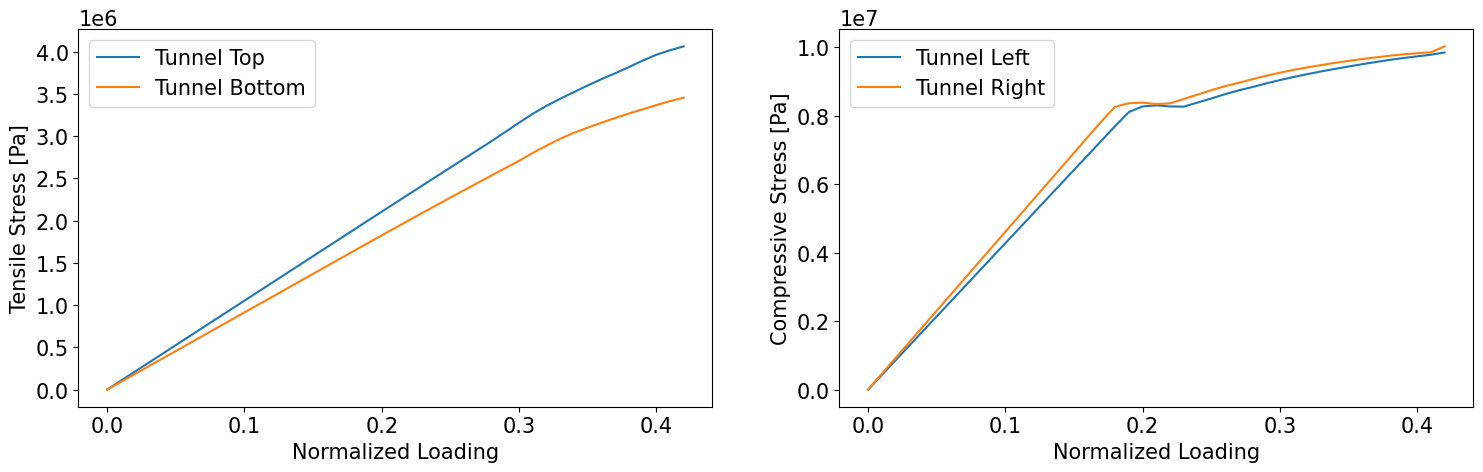

In [ ]:
# plot stress evolution curves recorded at critical points in the tunnel inner arches
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
axes[0].plot(steps[:len(sigt_top)], sigt_top, steps[:len(sigt_top)], sigt_bottom, "-")
axes[0].set(xlabel='Normalized Loading', ylabel='Tensile Stress [Pa]');
axes[0].legend(['Tunnel Top', 'Tunnel Bottom'])
axes[1].plot(steps[:len(sigc_left)], sigc_left_mag, steps[:len(sigc_right)], sigc_right_mag, "-")
axes[1].set(xlabel='Normalized Loading', ylabel='Compressive Stress [Pa]');
axes[1].legend(['Tunnel Left', 'Tunnel Right'])
plt.show()

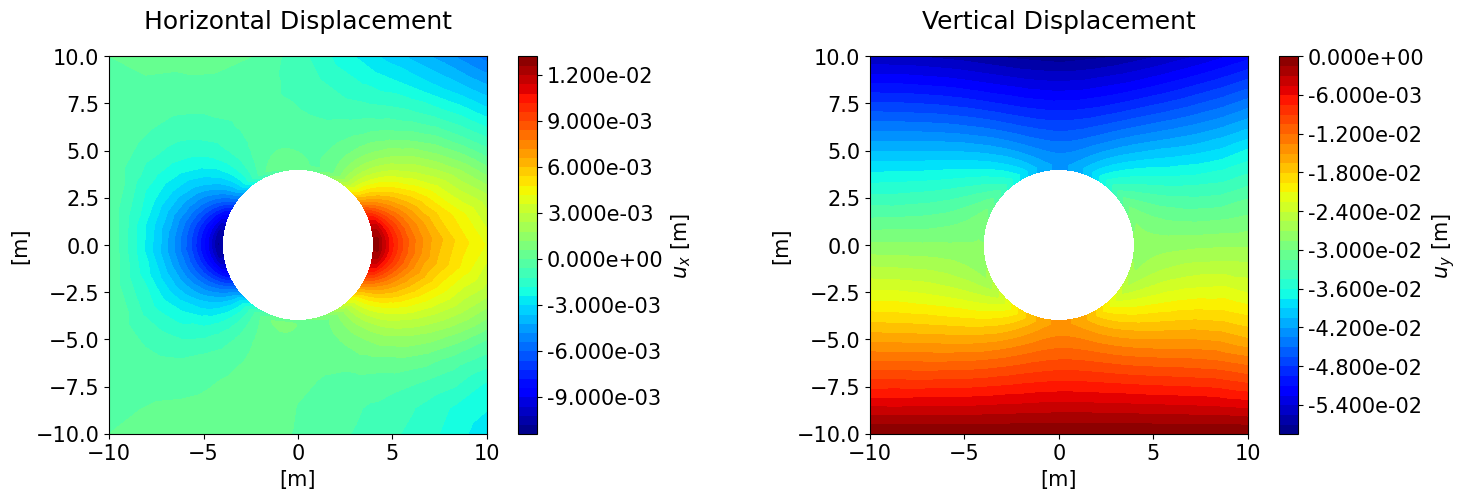

In [ ]:
# plot displacement fields
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [m]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [m]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');

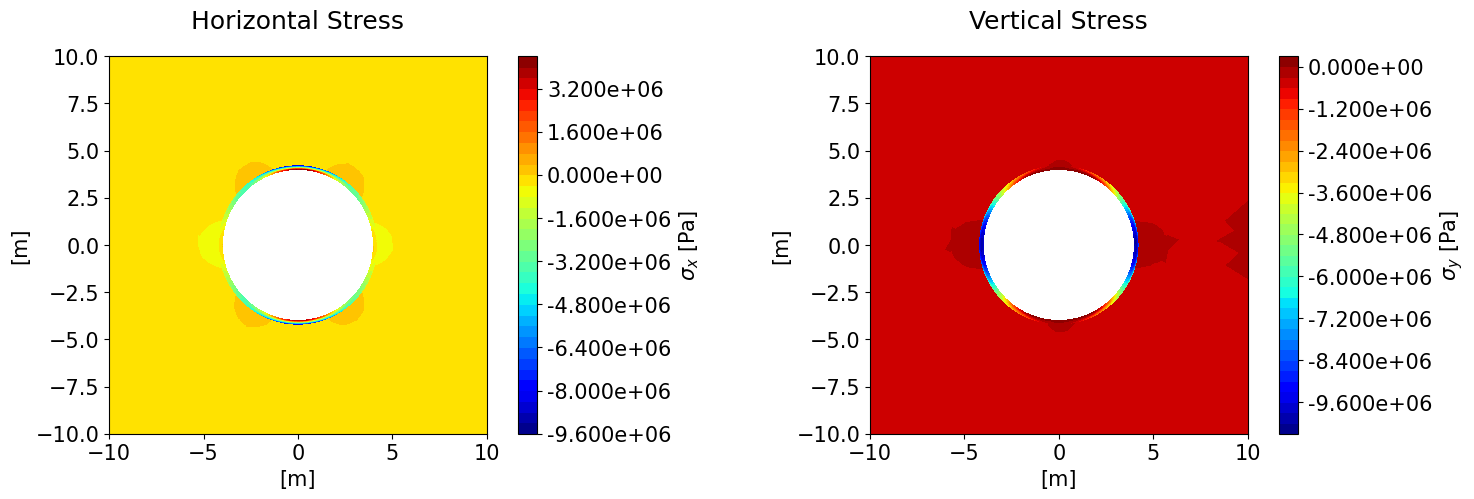

In [ ]:
# plot stress fields
fig, axes = plt.subplots(1, 2, figsize=(18, 5), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(sig_vector.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [Pa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
tc = tricontourf(sig_vector.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [Pa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');

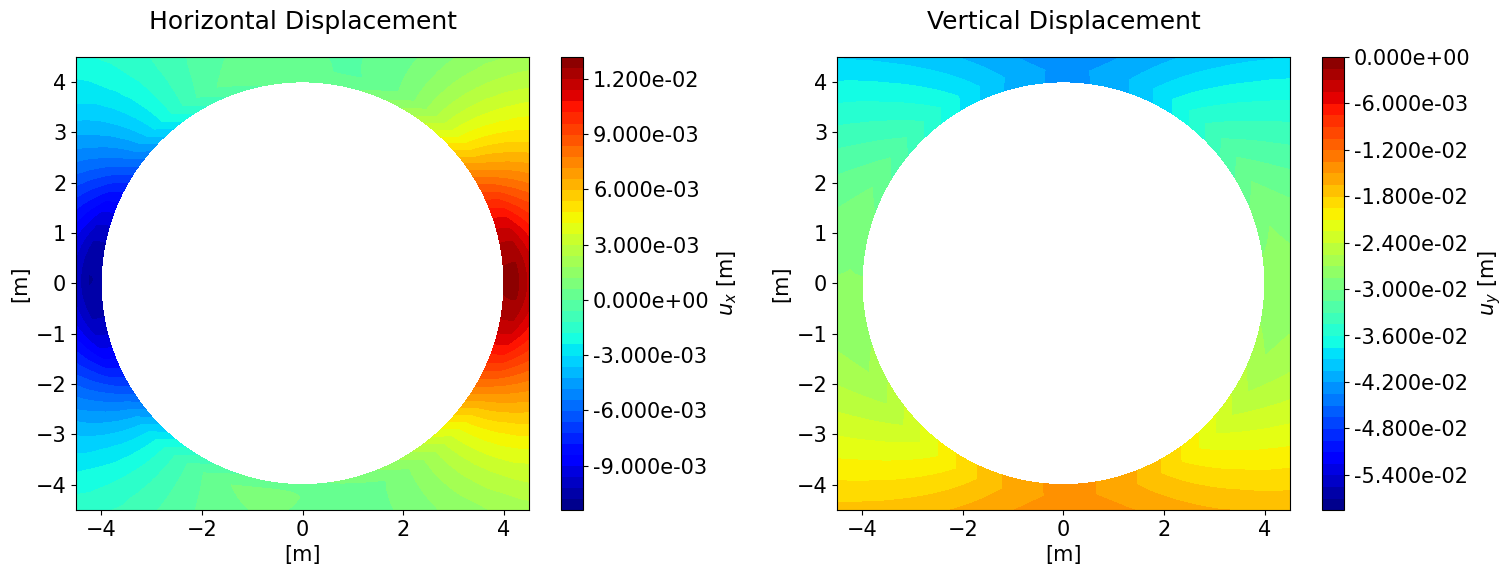

In [ ]:
# plot close-up veiw of the displacement fields
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(u.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$u_x$ [m]', format='%.3e')
axes[0].set_title('Horizontal Displacement', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
axes[0].set_xlim([-4.5, 4.5])
axes[0].set_ylim([-4.5, 4.5])
tc = tricontourf(u.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$u_y$ [m]', format='%.3e')
axes[1].set_title('Vertical Displacement', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');
axes[1].set_xlim([-4.5, 4.5])
axes[1].set_ylim([-4.5, 4.5])
plt.show()

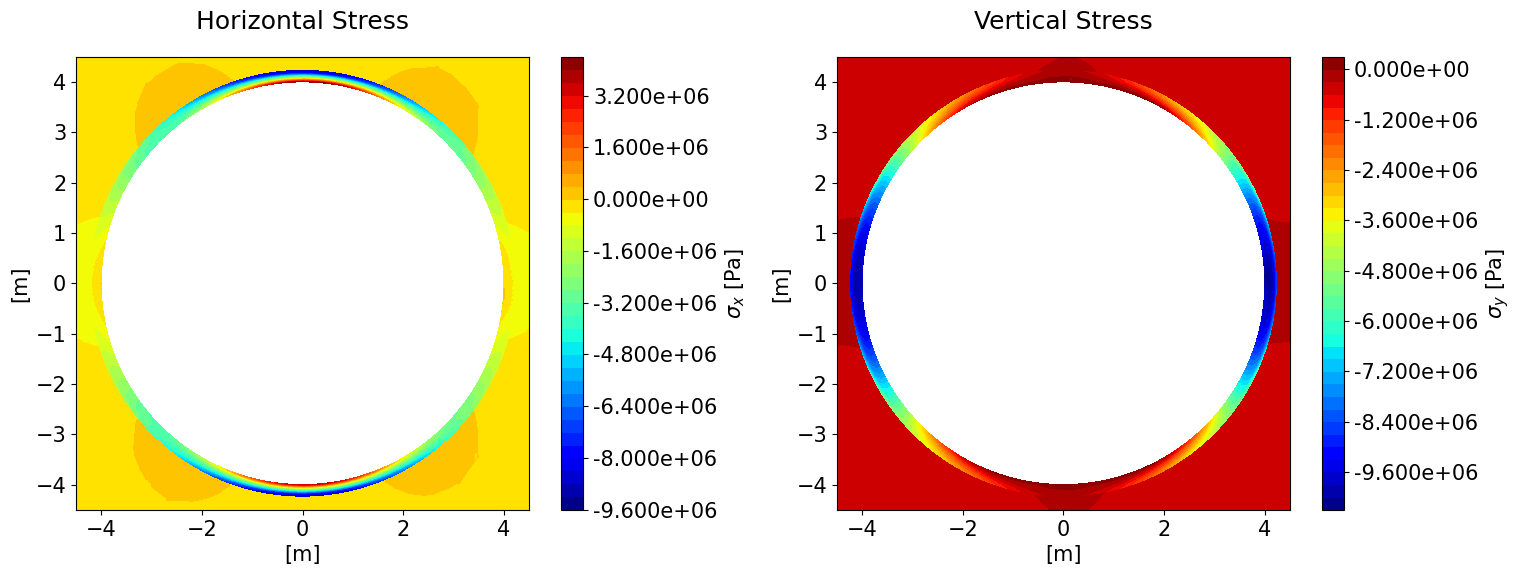

In [ ]:
# plot close-up veiw of the stress fields
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(sig_vector.sub(0), levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\sigma_x$ [Pa]', format='%.3e')
axes[0].set_title('Horizontal Stress', pad=20)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
axes[0].set_xlim([-4.5, 4.5])
axes[0].set_ylim([-4.5, 4.5])
tc = tricontourf(sig_vector.sub(1), levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\sigma_y$ [Pa]', format='%.3e')
axes[1].set_title('Vertical Stress', pad=20)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');
axes[1].set_xlim([-4.5, 4.5])
axes[1].set_ylim([-4.5, 4.5])
plt.show()

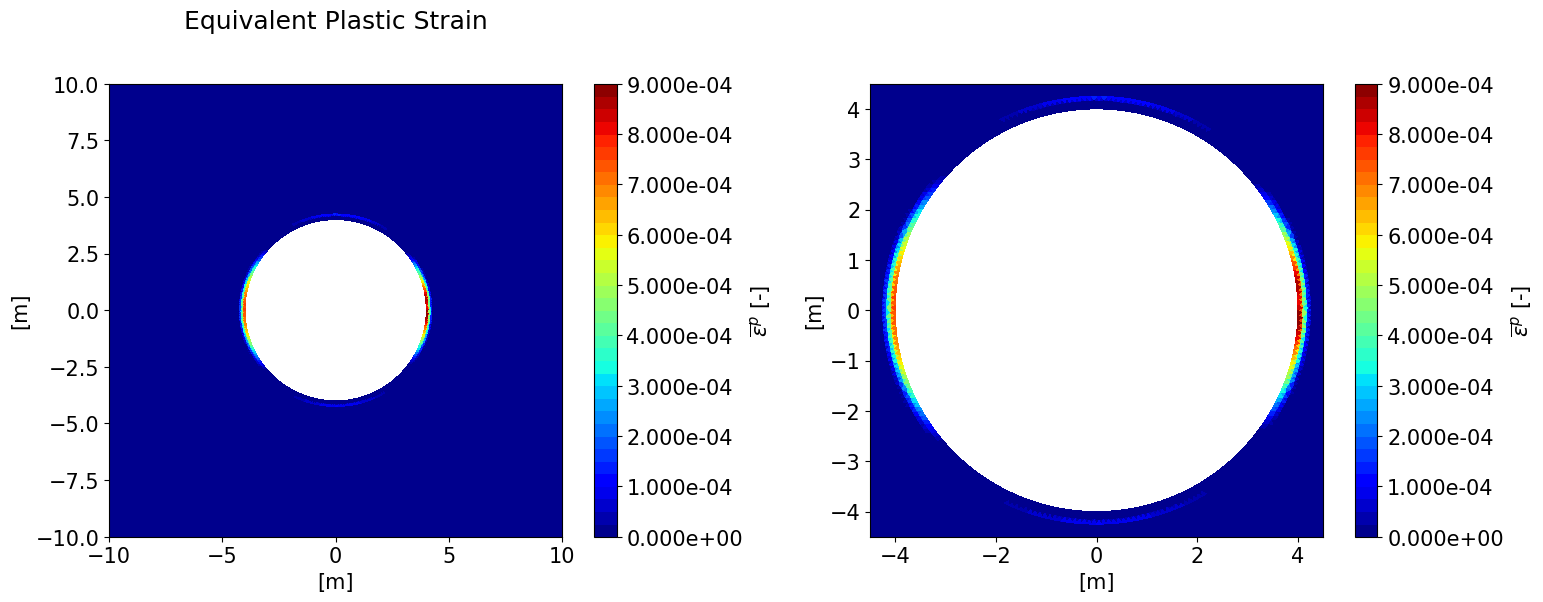

In [ ]:
# plot the field of equivalent plastic strain: global view (left) & close-up view (right)
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=100)
plt.rcParams.update({'font.size': 15})
tc = tricontourf(ep_avg, levels=40, axes=axes[0], cmap='jet')
cb = plt.colorbar(tc, ax=axes[0], label='$\overline{\epsilon}^p$ [-]', format='%.3e')
axes[0].set_title('Equivalent Plastic Strain', pad=40)
axes[0].set_aspect("equal")
axes[0].set(xlabel='[m]', ylabel='[m]');
tc = tricontourf(ep_avg, levels=40, axes=axes[1], cmap='jet')
cb = plt.colorbar(tc, ax=axes[1], label='$\overline{\epsilon}^p$ [-]', format='%.3e')
# axes[1].set_title('Equivalent Plastic Strain', pad=40)
axes[1].set_aspect("equal")
axes[1].set(xlabel='[m]', ylabel='[m]');
axes[1].set_xlim([-4.5, 4.5])
axes[1].set_ylim([-4.5, 4.5])
plt.show()